<a href="https://colab.research.google.com/github/MmV0/Portfolio-optimizer/blob/main/Portfolio_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import seaborn as sn
import scipy.optimize as sco

In [7]:
# Some style things
plt.style.use('fivethirtyeight')
np.random.seed(32)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# **Dataset preparation and analysis**

### **Pull the stock price data**


We downloaded the 10 years of daily historical data for selected stocks from 1 January 2011 to 31 December 2020. We only focused on the column 'Adj Close', as this column provides us with the closing price of the company's shares on a given day.

In [ ]:
# Install libraries
!pip install yfinance

In [4]:
import yfinance as yf

# List with the stock chosen
tickers = ['WDC', 'DXC', 'HPQ', 'MU', 'PENN', 'F', 'TJX', 'MAR', 'PKI', 'A', 'CI', 'XRAY', 'LYB', 'NUE', 'CE', 'IP', 'WFC', 'RE', 'DFS', 'COF']

# Download 10 years of historical daily data
df = yf.download(tickers, 
                         start = '2011-01-01',
                         end = '2020-12-31')['Adj Close'] # Closing price

[*********************100%***********************]  20 of 20 completed


In [5]:
# Show fist 5 rows of the df
df.head(5)

,A,CE,CI,COF,DFS,DXC,F,HPQ,IP,LYB,MAR,MU,NUE,PENN,PKI,RE,TJX,WDC,WFC,XRAY
Date,,,,,,,,,,,,,,,,,,,,
2011-01-03,27.299471,35.146610,36.807018,36.697838,15.235926,15.726137,11.498730,14.302153,17.023096,18.786114,34.882645,8.248363,31.506168,7.825006,24.268538,66.784752,9.448826,27.407520,22.997028,32.609341
2011-01-04,27.045250,34.664459,36.476131,36.689434,15.066003,15.729228,11.585386,14.599981,16.889427,18.954630,34.193146,8.407752,31.235361,7.680307,23.987442,65.867676,9.399221,26.484299,23.048004,32.247021
2011-01-05,26.986576,34.672768,36.592922,38.234962,15.511030,15.791095,11.925344,14.790716,17.095995,18.943758,34.533730,8.507370,31.584557,7.691612,23.809410,65.256241,9.274127,26.323742,23.572323,32.553600
2011-01-06,27.038733,35.088413,37.965145,38.134159,15.365382,15.970500,12.145323,15.018270,16.944109,19.008984,33.952229,8.547218,31.292372,7.653177,24.146732,65.287590,9.817635,26.500353,23.412117,32.367790
2011-01-07,27.129988,35.163231,38.354439,38.142570,15.292559,16.100424,12.178652,15.088547,17.004868,18.818737,33.902382,8.616950,31.349384,7.856658,24.015545,64.754585,9.845673,26.516417,22.938766,32.237713


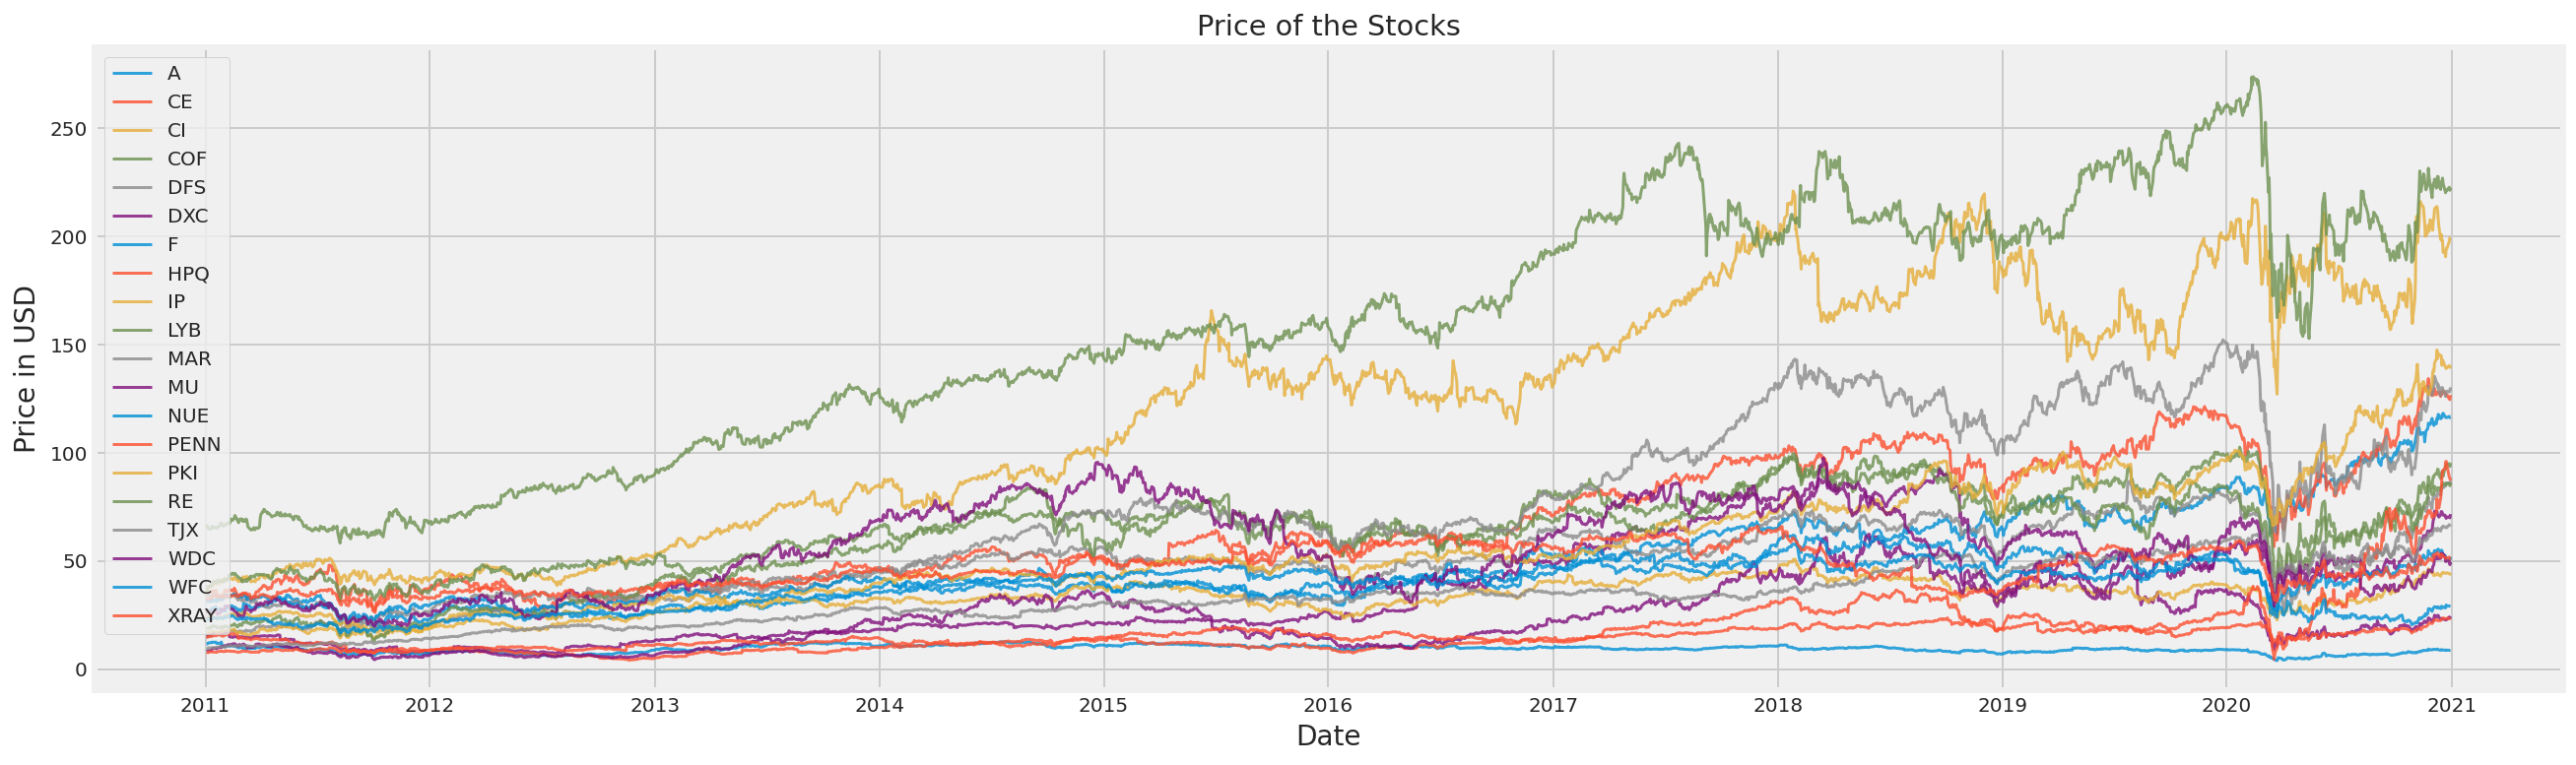

In [8]:
# Plot stocks price
plt.figure(figsize=(20,6)) 
for i in df.columns.values:
    plt.plot( df[i],  label=i, lw=1.5, alpha=0.8)
plt.title('Price of the Stocks')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in USD',fontsize=14)
plt.legend(df.columns.values, loc='upper left')
plt.show()

### **Logarithmic Returns (expected returns)**
Expected returns of an asset are simply the mean of percentage change in its stock prices. So, the value of expected return we obtain here are daily expected returns. We use the following formula:

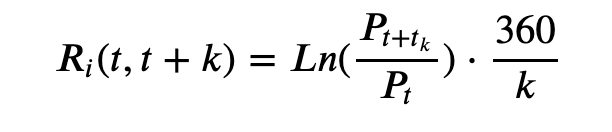

We remove the missing values because due to the logarithmic transformation we lose the first data. The resulting dataframe is the following:

In [9]:
returns = df.pct_change().apply(lambda x: np.log(1+x)).dropna()
returns.head()

,A,CE,CI,COF,DFS,DXC,F,HPQ,IP,LYB,MAR,MU,NUE,PENN,PKI,RE,TJX,WDC,WFC,XRAY
Date,,,,,,,,,,,,,,,,,,,,
2011-01-04,-0.009356,-0.013813,-0.009030,-0.000229,-0.011215,0.000197,0.007508,0.020610,-0.007883,0.008930,-0.019964,0.019139,-0.008633,-0.018665,-0.011650,-0.013827,-0.005264,-0.034265,0.002214,-0.011173
2011-01-05,-0.002172,0.000240,0.003197,0.041262,0.029111,0.003926,0.028921,0.012979,0.012156,-0.000574,0.009911,0.011779,0.011117,0.001471,-0.007450,-0.009326,-0.013398,-0.006081,0.022494,0.009462
2011-01-06,0.001931,0.011916,0.036814,-0.002640,-0.009434,0.011297,0.018278,0.015268,-0.008924,0.003437,-0.016982,0.004673,-0.009294,-0.005010,0.014068,0.000480,0.056952,0.006687,-0.006820,-0.005724
2011-01-07,0.003369,0.002130,0.010202,0.000221,-0.004751,0.008102,0.002740,0.004669,0.003579,-0.010059,-0.001469,0.008125,0.001820,0.026240,-0.005448,-0.008197,0.002852,0.000606,-0.020425,-0.004027
2011-01-10,0.014313,0.012918,-0.003304,0.003518,0.011573,-0.002693,0.002187,-0.005114,0.004634,0.017750,-0.006885,-0.011628,-0.005471,0.019944,0.006224,-0.000727,-0.001534,-0.005769,-0.009569,0.010322


Below we plotted the daily returns instead of actual prices, in order to see the stocks' volatility during the time.



Text(0, 0.5, 'daily returns')

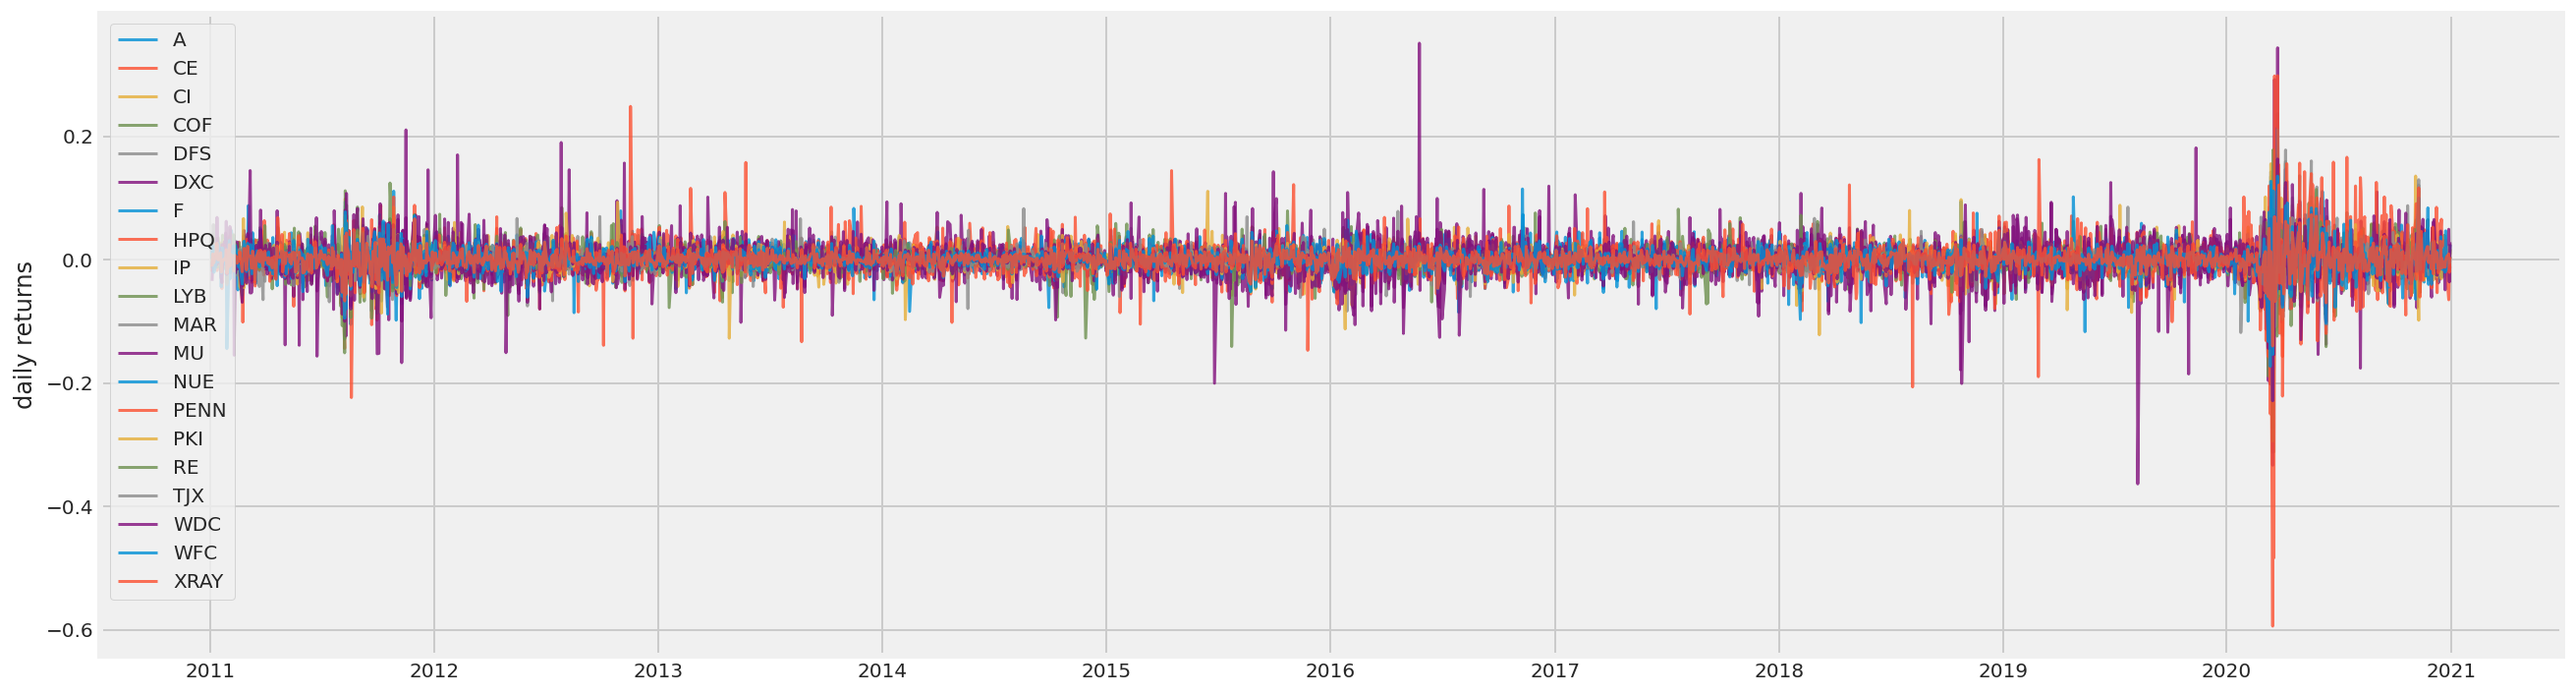

In [10]:
plt.figure(figsize=(20, 6))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=1.5, alpha=0.8,label=c)
plt.legend(loc='upper left')
plt.ylabel('daily returns')

We verify if the returns are normally distributed

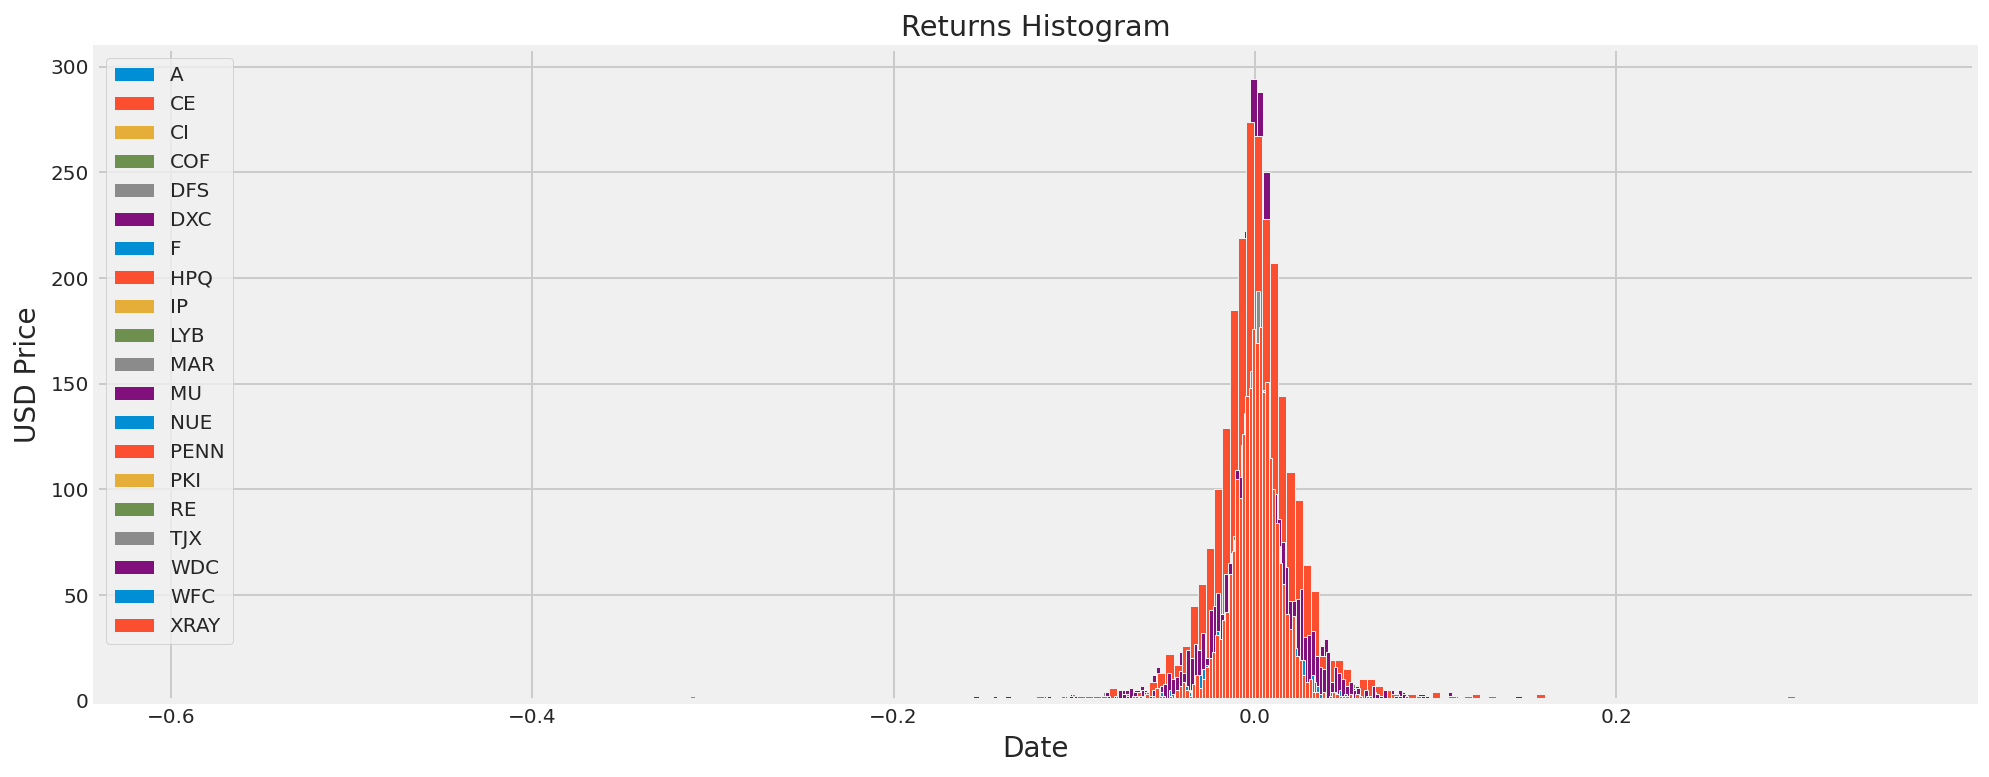

In [11]:
plt.figure(figsize=(15,6)) 
for i in returns.columns.values:
    plt.hist( returns[i],  label=i, bins = 200)
plt.title('Returns Histogram')
plt.xlabel('Date',fontsize=14)
plt.ylabel('USD Price',fontsize=14)
plt.legend(returns.columns.values, loc='upper left')
plt.show()

### **Annual Covariance and Correlation matrix**
We calculated the covariance and correlation matrix to understand how different assets behave with respect to each other. It's based on the annual return of the different portfolio's assets. 


###### **Covariance matrix**
Covariance measures the directional relationship between the returns on two assets. A positive covariance means that returns of the two assets move together while a negative covariance means they move inversely. Risk and volatility can be reduced in a portfolio by pairing assets that have a negative covariance.

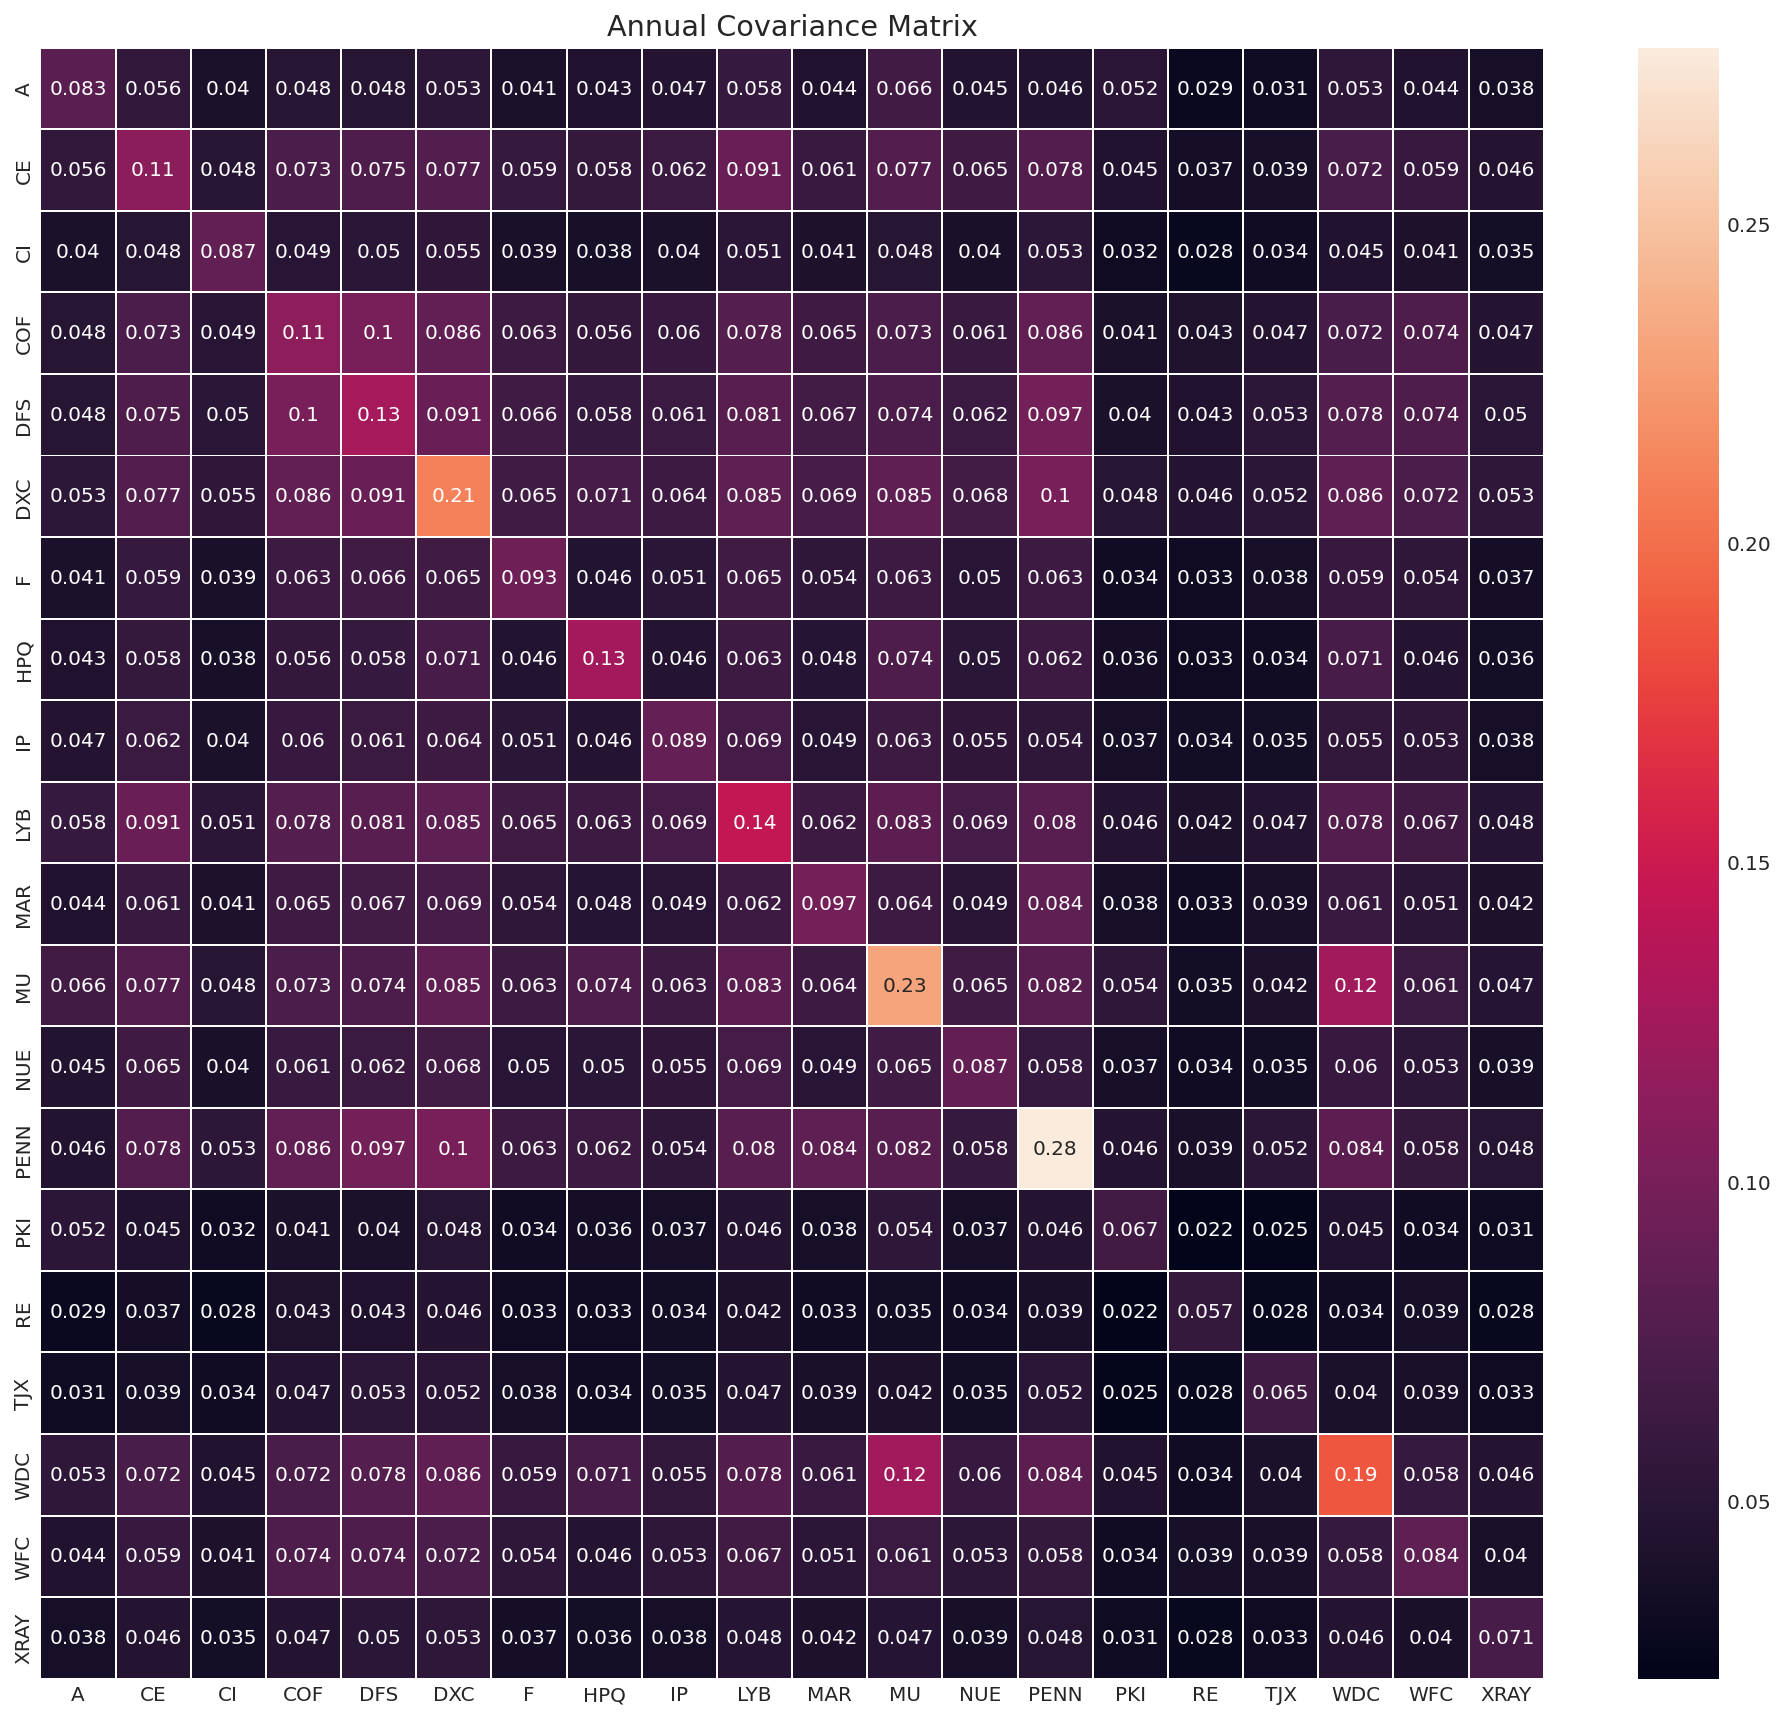

In [12]:
# Covariance matrix
cov_matrix = returns.cov()*252

# Plot Covariance matrix
f, ax = plt.subplots(figsize=(15, 15))
sn.heatmap(cov_matrix, annot=True, linewidths=.5, ax=ax).set_title('Annual Covariance Matrix')
plt.show()

###### **Correlation matrix**

The next step is to create the correlation matrix. Correlation, in the finance and investment industries, is a statistic that measures the degree to which two securities move in relation to each other. Correlations are used in advanced portfolio management, computed as the correlation coefficient, which has a value that must fall between -1.0 and +1.0.


* -1 means negative relation i.e, if correlation between Asset A and Asset B is -1, if Asset A increases, Asset B decreases.
* 0 means no relation, i.e, if correlation between Asset A and Asset B is 0, they dont have any effect on each other.
* +1 means positive relation, i.e, if correlation between Asset A and Asset B is 1, if Asset A increases, Asset B increases.




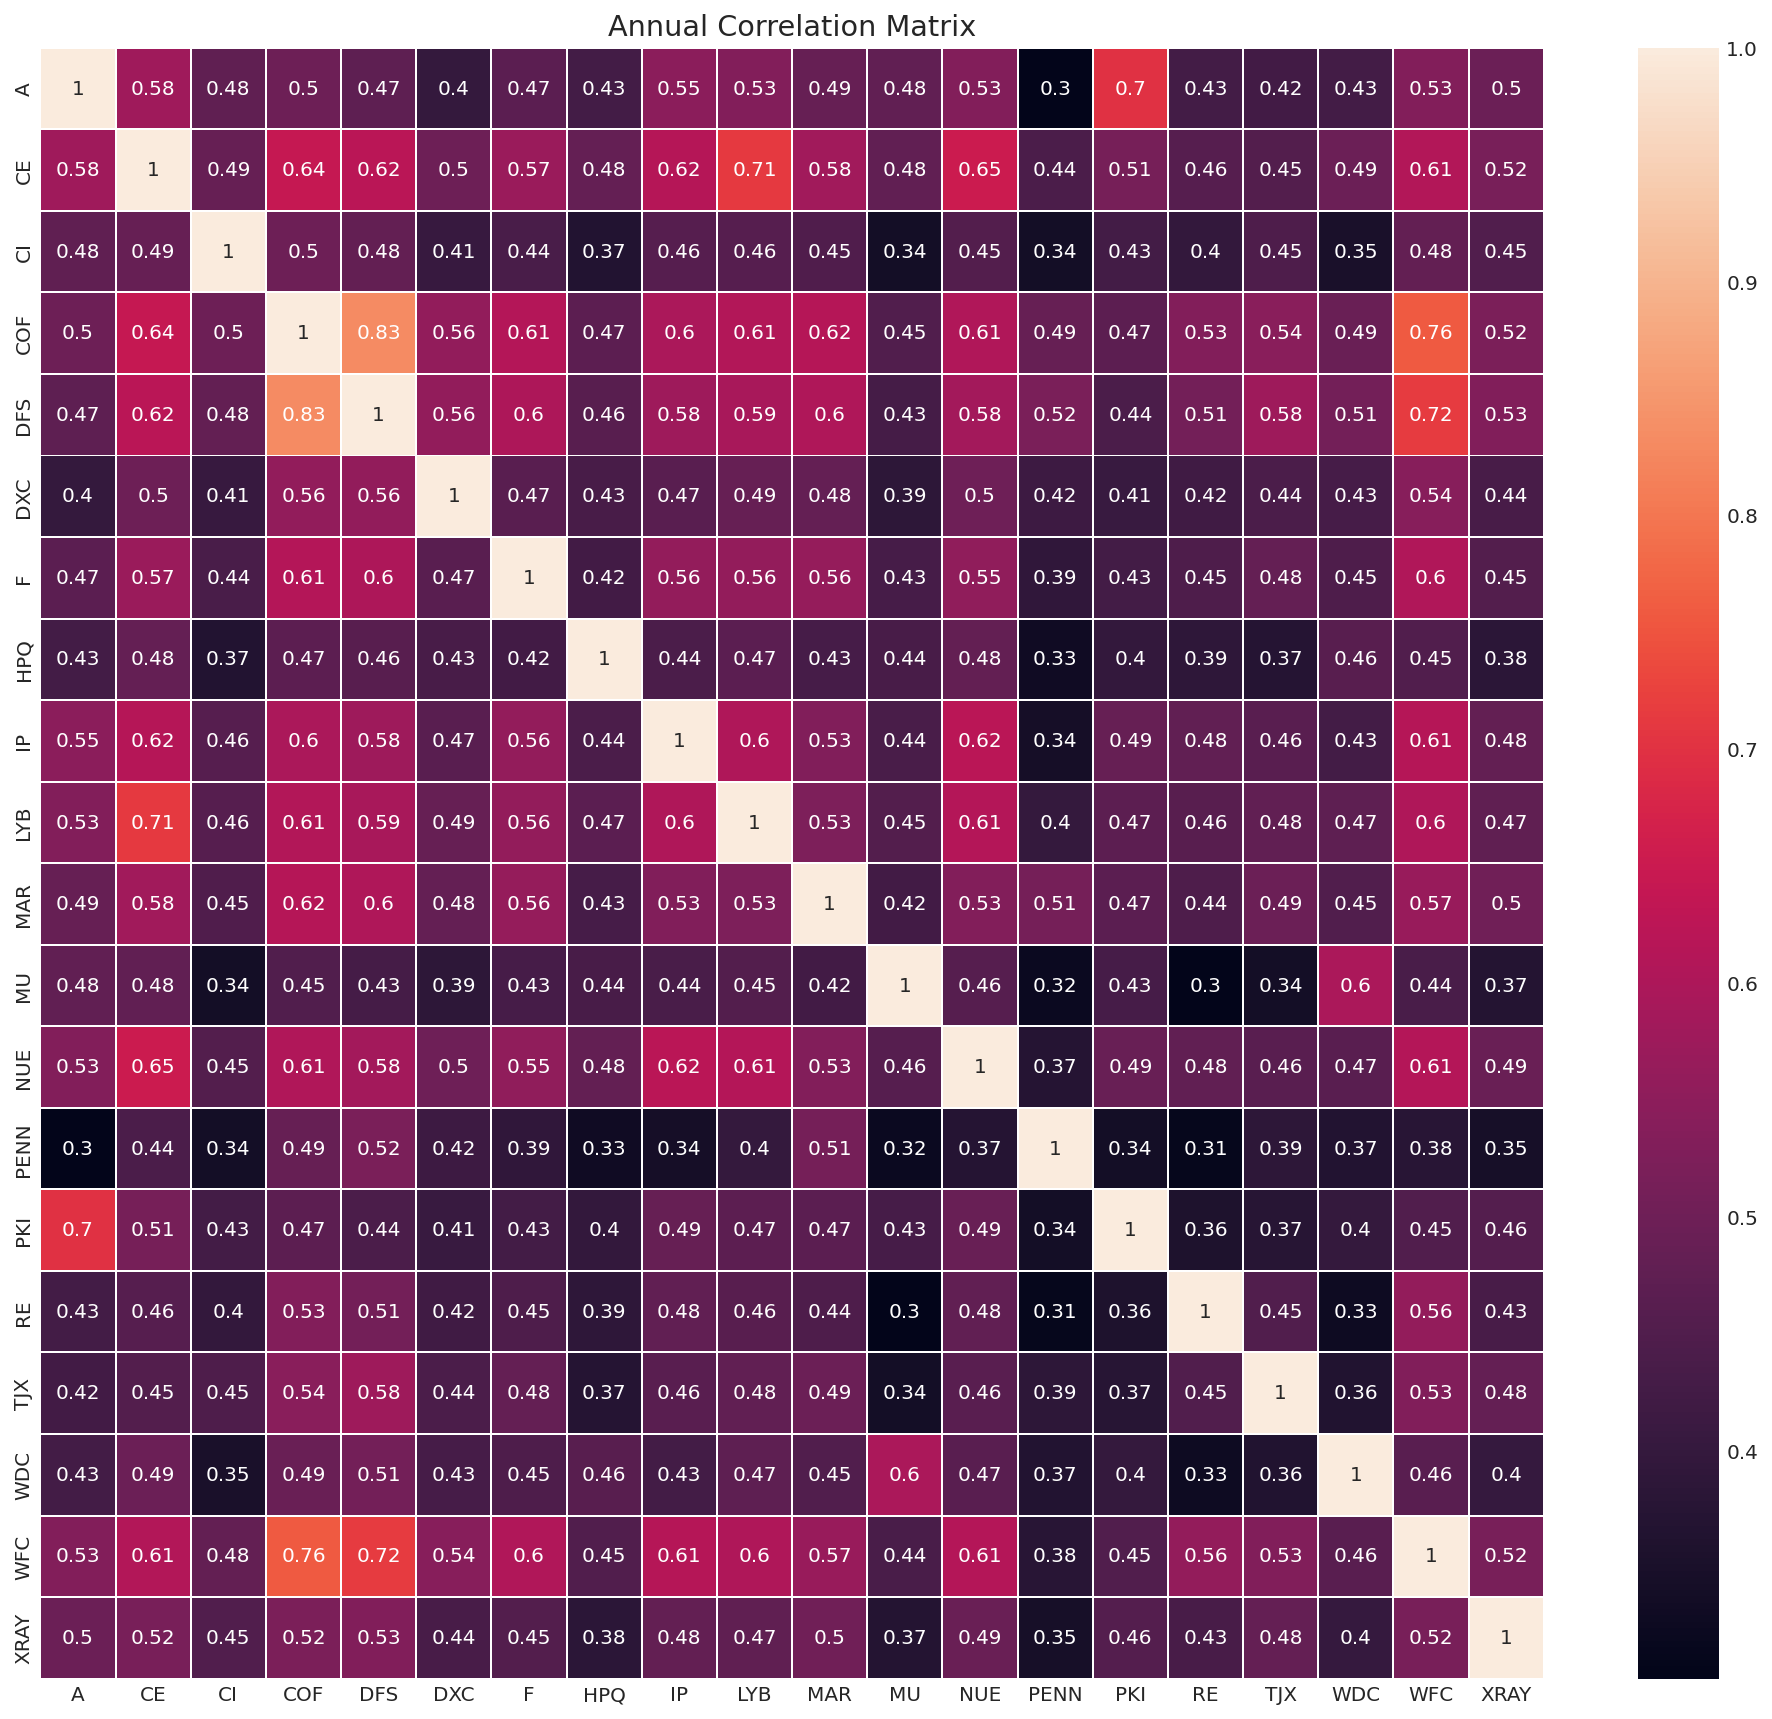

In [13]:
# Correlation matrix
corr_matrix = returns.corr()

# Plot correlation matrix
f, ax = plt.subplots(figsize=(15, 15))
sn.heatmap(corr_matrix, annot=True, linewidths=.5, ax=ax).set_title('Annual Correlation Matrix')
plt.show()

# **Building an optimal risky portfolio**

### **Long selling portfolio**

In [20]:
# Parameter to set
returns = df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

num_portfolios = 2500
risk_free_rate = 0.0118

In [21]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
  '''
  This function calculates the returns and volatility, and to make it as an annualised 
  calculation I take into account 252 as the number of trading days in one year
  '''
  returns = np.sum(mean_returns*weights)*252
  std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
  return std, returns

In [22]:
# Makes the random numbers predictable (32 = number of our group)
np.random.seed(32)

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate, short = False):
  '''
  This function generates portfolios with random weights assigned to each stock, 
  and by passing num_portfolios argument, you can decide how many random 
  portfolios you want to generate.
  '''
  # Initialise an array with 3 columns and n 0 equal to the number of portfolios
  results = np.zeros((3,num_portfolios))
  weights_record = []
  for i in range(num_portfolios):
    # Condition for short selling
    if short == False:
      # Random weights
      weights = np.random.random(len(df.columns))
      weights /= np.sum(weights)
      # Save Weight
      weights_record.append(weights)
    else: 
      # Random weights
      weights = np.random.uniform(low=-1, high=1, size=len(df.columns))
      weights /= np.sum(weights)
      # Save Weight
      weights_record.append(weights)

    portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    # Save Standard Deviation = Volatility
    results[0,i] = portfolio_std_dev
    # Save Return
    results[1,i] = portfolio_return
    # Save Sharpe Ratio
    results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
  return results, weights_record

In [23]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [27]:
# Makes the random numbers predictable (32 = number of our group)
np.random.seed(48)

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, short = False):
  results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate, short = short)
  
  ''' Selection of the MAX Sharp Ratio portfolio'''
  # Selects the index of the max Sharpe ratio 
  max_sharpe_idx = np.argmax(results[2])
  # Selects standard deviation and return
  sdp, rp, sr = results[0,max_sharpe_idx], results[1,max_sharpe_idx], results[2,max_sharpe_idx]
  # Makes a df with weights of stocks in %
  max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=df.columns,columns=['allocation'])
  max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
  max_sharpe_allocation = max_sharpe_allocation.T
  
  ''' Selection of the min Volatility portfolio'''
  # Selects the index of the min standard deviation (volatility) 
  min_vol_idx = np.argmin(results[0])
  # Selects standard deviation and return
  sdp_min, rp_min, sr_min = results[0,min_vol_idx], results[1,min_vol_idx], results[2,min_vol_idx]
  # Makes a df with weights of stocks in %
  min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=df.columns,columns=['allocation'])
  min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
  min_vol_allocation = min_vol_allocation.T
  
  # Print some info about the two portfolios
  print("-"*80)
  print("Maximum Sharpe Ratio Portfolio Allocation\n")
  print("Annualised Return:", round(rp,2))
  print("Annualised Volatility:", round(sdp,2))
  print("Sharpe Ratio:", round(sr,2))
  print("\n")
  print(max_sharpe_allocation)
  print("-"*80)
  print("Minimum Volatility Portfolio Allocation\n")
  print("Annualised Return:", round(rp_min,2))
  print("Annualised Volatility:", round(sdp_min,2))
  print("Sharpe Ratio:", round(sr_min,2))
  print("\n")
  print(min_vol_allocation)
  print("\n")
  
  # Plot the scatterplot
  plt.figure(figsize=(12, 6))
  plt.scatter(results[0,:],results[1,:],c=results[2,:], cmap='viridis', marker='o', s=10)
  plt.colorbar(label='Sharpe Ratio')
  plt.scatter(sdp,rp,marker='*',color='r',s=100, label='Maximum Sharpe ratio')
  plt.scatter(sdp_min,rp_min,marker='*',color='g',s=100, label='Minimum volatility')
  plt.title('Simulated Portfolio Optimization based on Efficient Frontier\n')
  plt.xlabel('Annualised volatility')
  plt.ylabel('Annualised returns')
  plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.24
Sharpe Ratio: 0.82


                A    CE    CI   COF   DFS   DXC     F   HPQ    IP  LYB   MAR    MU   NUE   PENN   PKI    RE  TJX   WDC   WFC  XRAY
allocation  10.66  0.28  5.58  6.39  0.26  4.52  0.43  3.88  8.14  1.6  5.27  11.4  1.42  10.24  8.98  2.48  7.8  0.65  0.08  9.94
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.16
Annualised Volatility: 0.22
Sharpe Ratio: 0.68


               A    CE    CI   COF   DFS   DXC     F   HPQ    IP   LYB   MAR    MU   NUE  PENN    PKI     RE   TJX   WDC   WFC  XRAY
allocation  1.41  5.65  1.76  2.24  0.56  5.16  9.49  7.85  1.52  1.16  3.91  2.66  6.11  5.96  12.06  10.52  9.22  1.88  1.21  9.67




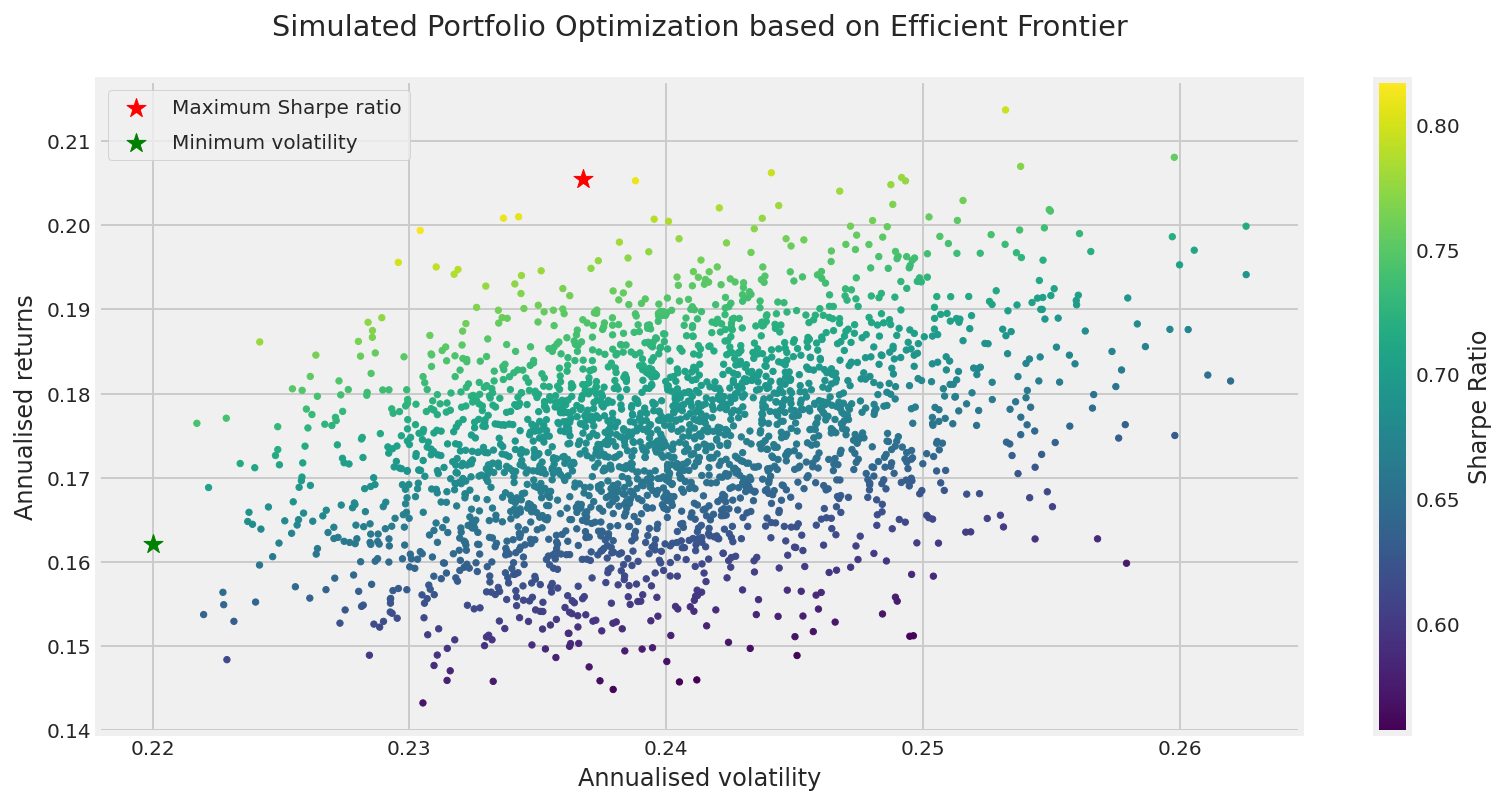

In [28]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

### **Long & Short selling portfolio**
Repeat the above step by allowing short selling.

In [29]:
# Makes the random numbers predictable
np.random.seed(48)

def display_simulated_ef_with_random_short(mean_returns, cov_matrix, num_portfolios, risk_free_rate, short = False):
  results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate, short = short)
  
  ''' Selection of the MAX Sharp Ratio portfolio'''
  # Selects the index of the max Sharpe ratio 
  max_sharpe_idx = np.argmax(results[2])
  # Selects standard deviation and return
  sdp, rp, sr = results[0,max_sharpe_idx], results[1,max_sharpe_idx], results[2,max_sharpe_idx]
  # Makes a df with weights of stocks in %
  max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=df.columns,columns=['allocation'])
  max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
  max_sharpe_allocation.to_csv('max_sharpe_allocation_short.csv')
  max_sharpe_allocation = max_sharpe_allocation.T
  
  ''' Selection of the min Volatility portfolio'''
  # Selects the index of the min standard deviation (volatility) 
  min_vol_idx = np.argmin(results[0])
  # Selects standard deviation and return
  sdp_min, rp_min, sr_min = results[0,min_vol_idx], results[1,min_vol_idx], results[2,min_vol_idx]
  # Makes a df with weights of stocks in %
  min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=df.columns,columns=['allocation'])
  min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
  min_vol_allocation.to_csv('min_vol_allocation_short.csv')
  min_vol_allocation = min_vol_allocation.T
  
  # Print some info about the two portfolios
  print("-"*80)
  print("Maximum Sharpe Ratio Portfolio Allocation\n")
  print("Annualised Return:", round(rp,2))
  print("Annualised Volatility:", round(sdp,2))
  print("Sharpe Ratio:", round(sr,2))
  print("\n")
  print(max_sharpe_allocation)
  print("-"*80)
  print("Minimum Volatility Portfolio Allocation\n")
  print("Annualised Return:", round(rp_min,2))
  print("Annualised Volatility:", round(sdp_min,2))
  print("Sharpe Ratio:", round(sr_min,2))
  print("\n")
  print(min_vol_allocation)
  print("\n")
  
  # Plot the scatterplot
  plt.figure(figsize=(12, 6))
  plt.scatter(results[0,:],results[1,:],c=results[2,:], cmap='viridis', marker='o', s=10)
  plt.colorbar(label='Sharpe Ratio')
  plt.scatter(sdp,rp,marker='*',color='r',s=100, label='Maximum Sharpe ratio')
  plt.scatter(sdp_min,rp_min,marker='*',color='g',s=100, label='Minimum volatility')
  plt.title('Simulated Portfolio Optimization based on Efficient Frontier (short selling)\n')
  plt.xlabel('Annualised volatility')
  plt.ylabel('Annualised returns')
  plt.axis([0, 1, -0.5, 0.75])  
  plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.41
Annualised Volatility: 0.34
Sharpe Ratio: 1.17


                A     CE     CI   COF    DFS   DXC     F    HPQ     IP   LYB    MAR     MU    NUE  PENN    PKI     RE    TJX   WDC    WFC   XRAY
allocation  14.57  26.79  22.03  8.65  29.86  8.13 -5.27 -20.85  36.77  20.8 -15.63  23.11 -29.68  4.94  30.59  24.42  41.46 -39.5 -37.35 -43.81
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.13
Annualised Volatility: 0.22
Sharpe Ratio: 0.53


                A     CE   CI   COF    DFS    DXC     F    HPQ     IP   LYB    MAR    MU    NUE  PENN    PKI     RE    TJX    WDC   WFC  XRAY
allocation  18.44  10.35  3.1 -18.5 -13.97  13.99  1.99  12.63  12.91 -8.11  13.31  1.88  14.11 -4.44  11.11  15.16  13.67 -14.91  9.99  7.31




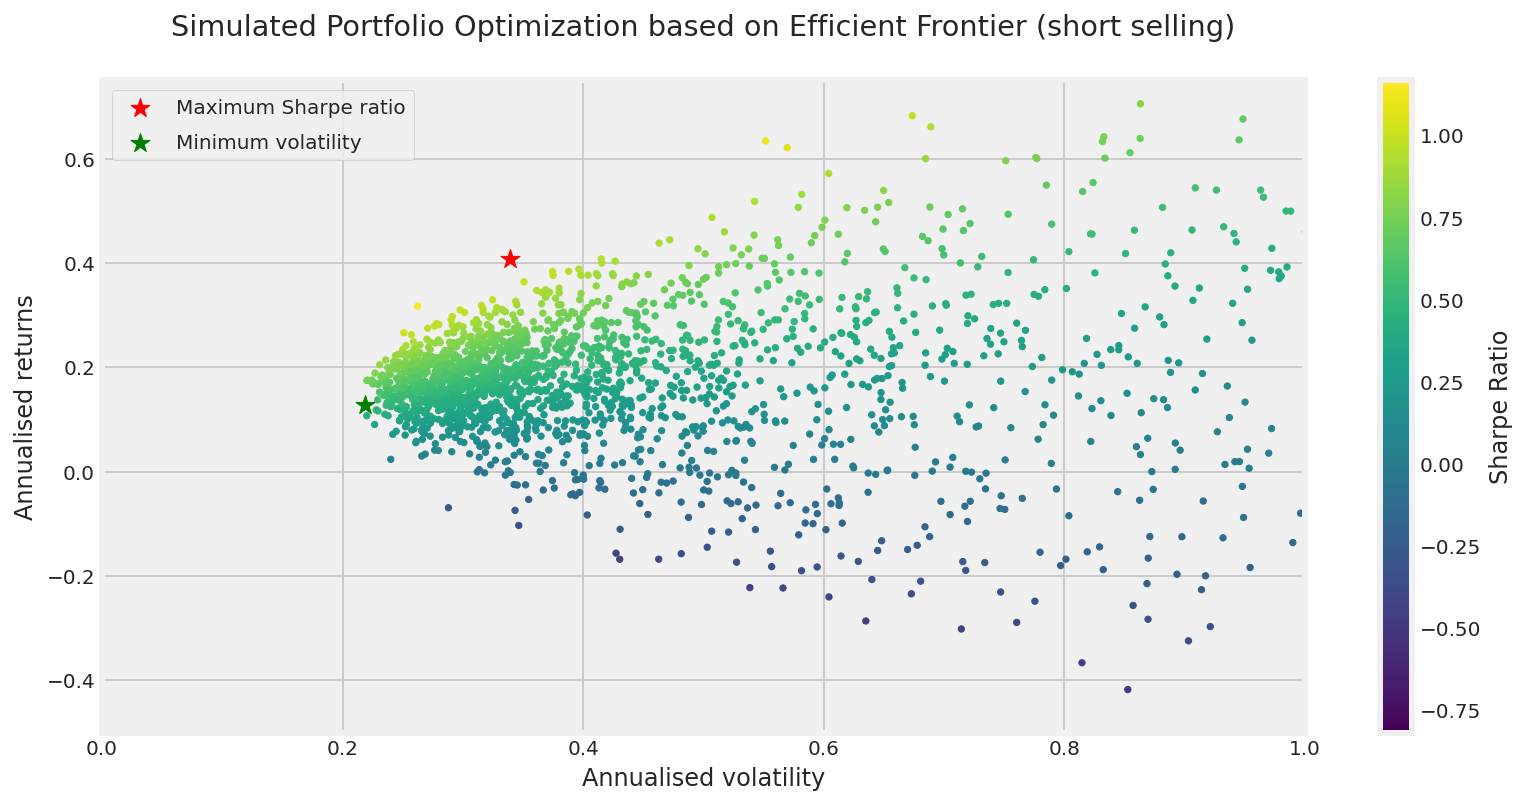

In [30]:
display_simulated_ef_with_random_short(mean_returns, cov_matrix, num_portfolios, risk_free_rate, short=True)

### **Market-capitalisation weighted portfolio**

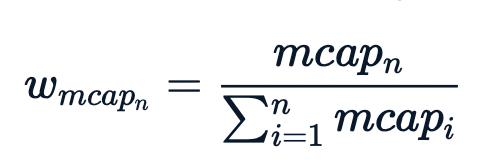

In [31]:
# Download Market Capitalization data for each stock
df_mcap = pd.DataFrame()

for ticker in tickers: 
    stock = yf.Ticker(ticker)
    marketcap = stock.info['marketCap']    
    df_mcap = df_mcap.append({'Stock':ticker,'marketcap':marketcap}, ignore_index=True)

In [32]:
# Makes the random numbers predictable
np.random.seed(48)

def market_cap_weighted_portfolio(mean_returns, cov_matrix, risk_free_rate):
  
  # Compute market cap weights
  market_capitalizations = df_mcap['marketcap']
  mcap_weights = market_capitalizations/sum(market_capitalizations)
  portfolio_std_dev, portfolio_return = portfolio_annualised_performance(mcap_weights.values, mean_returns, cov_matrix)
  mcap_sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
  
  mcap_weights.to_csv('market_cap_weight.csv')

  # Makes a df with weights of stocks in %
  mcap_allocation = mcap_weights.to_frame().set_index(df.columns).rename(columns={'marketcap':'allocation'})
  mcap_allocation.allocation = [round(i*100,2)for i in mcap_allocation.allocation]
  mcap_allocation.to_csv('mcap_allocation_cap.csv')
  mcap_allocation = mcap_allocation.T
  


  # Print some info about the two portfolios
  print("-"*80)
  print("Market-capitalisation Weighted Portfolio\n")
  print("Annualised Return:", round(portfolio_return,2))
  print("Annualised Volatility:", round(portfolio_std_dev,2))
  print("Sharpe Ratio:", round(mcap_sharpe_ratio,2))
  print("\n")
  print(mcap_allocation)
  print("\n")

In [33]:
market_cap_weighted_portfolio(mean_returns, cov_matrix, risk_free_rate)

--------------------------------------------------------------------------------
Market-capitalisation Weighted Portfolio

Annualised Return: 0.17
Annualised Volatility: 0.23
Sharpe Ratio: 0.67


               A    CE    CI   COF  DFS  DXC     F   HPQ   IP  LYB    MAR    MU   NUE  PENN   PKI    RE   TJX   WDC   WFC  XRAY
allocation  2.17  0.96  4.55  9.13  0.6  6.0  8.59  6.27  2.2  4.4  10.07  0.97  4.34  4.39  1.93  2.13  20.4  1.25  3.67   6.0




### **Equally weighted portfolio of the stocks**

In [34]:
# Makes the random numbers predictable

def equally_weighted_portfolio(mean_returns, cov_matrix, risk_free_rate):

  # Compute equally weight weights
  numstocks = len(tickers)
  ew_weights = pd.Series(1/numstocks).repeat(numstocks).reset_index(drop=True)
  portfolio_std_dev, portfolio_return = portfolio_annualised_performance(ew_weights.values, mean_returns, cov_matrix)
  ew_sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
  
  # Makes a df with weights of stocks in %
  ew_allocation = ew_weights.to_frame().set_index(df.columns).rename(columns={0:'allocation'})
  ew_allocation.allocation = [round(i*100,2)for i in ew_allocation.allocation]
  ew_allocation = ew_allocation.T
  
  # Print some info about the two portfolios
  print("-"*80)
  print("Equally Weighted Portfolio\n")
  print("Annualised Return:", round(portfolio_return,2))
  print("Annualised Volatility:", round(portfolio_std_dev,2))
  print("Sharpe Ratio:", round(ew_sharpe_ratio,2))
  print("\n")
  print(ew_allocation)
  print("\n")

In [35]:
equally_weighted_portfolio(mean_returns, cov_matrix, risk_free_rate)

--------------------------------------------------------------------------------
Equally Weighted Portfolio

Annualised Return: 0.17
Annualised Volatility: 0.24
Sharpe Ratio: 0.68


              A   CE   CI  COF  DFS  DXC    F  HPQ   IP  LYB  MAR   MU  NUE  PENN  PKI   RE  TJX  WDC  WFC  XRAY
allocation  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0   5.0  5.0  5.0  5.0  5.0  5.0   5.0


